# Предсказание заказов для службы такси

Компания агрегатор такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Оглавление

Нашу работу по подбору и созданию модели разделим на следующие части:

### [**Часть 1.** Подготовка данных](#step_1)

### [**Часть 2.** Анализ](#step_2)

### [**Часть 3.** Обучение](#step_3)

### [**Часть 4.** Тестирование](#step_4)

### [**Часть 5.** Общий вывод](#step_5)

<font color='green'>Хорошо, что используешь план с использованием ссылок!</font>

# 1. Подготовка <a id='step_1'></a>

Для начала импортируем все библиотеки, которые будем в дальнейшем использовать в проекте и пропишем настройки для графиков.

In [1]:
import pandas as pd
import numpy as np
from IPython.display          import display
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression
from sklearn.ensemble         import RandomForestRegressor
from sklearn.neighbors        import KNeighborsRegressor
from sklearn.metrics          import mean_squared_error
from lightgbm                 import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(palette="muted")

Заказчик нам предал данные в файле `taxi.csv`. Откроем его и изучим.

In [2]:
print(pd.read_csv('taxi.csv').info())
display(pd.read_csv('taxi.csv').head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


В данных две колонки: `datetime` - метки времени, с шагом в 10 минут и `num_orders` - количество заказов за промежуток между двумя метками. Для удобства, при сохранении этого файла сразу укажем первый столбец как индексы, задим им формат даты и проведем ресэмплинг с шагом в 1 час, выбрав в качестве агрегирующей функции сумму значений.

<font color='green'>Верно</font>

In [3]:
taxi = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0]).resample('1H').sum()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Таким образом мы получили таблицу, состоящую из 4416 записей с количеством заказов такси и временными метками этих заказов.

# 2. Анализ <a id='step_2'></a>

В данном разделе мы изучим и проанализируем предоставленные нам данные. Начнем с проверки монотонности временных меток, а также уточним, за какой промежуток нам предоставлена информация.

In [4]:
if taxi.index.is_monotonic:
    print("Данные монотонны")
else:
    print("Данные немонотонны")
    
print("Время первой метки:   ", taxi.index.min())
print("Время последней метки:", taxi.index.max())

Данные без пропусков
Время первой метки:    2018-03-01 00:00:00
Время последней метки: 2018-08-31 23:00:00


Как мы видим данные идут монотонно, начинаются первого марта и заканчиваются 31-го августа, т.е. нам предоставлены данные за полные 6 месяцев. Далее, изучим вид распределения, для этого построим график временного распределения количества заказов. 

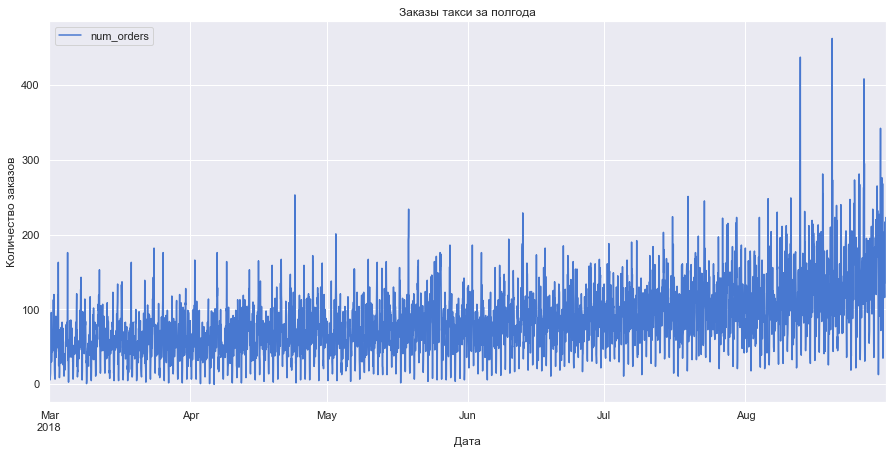

In [5]:
taxi.plot(figsize = (15, 7),
          title = 'Заказы такси за полгода')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

В таком виде ничего не понятно, но к июлю августу вроде количество заказов немного растет. Для лучшего понимания динамики построим график скользящего среднего за сутки.

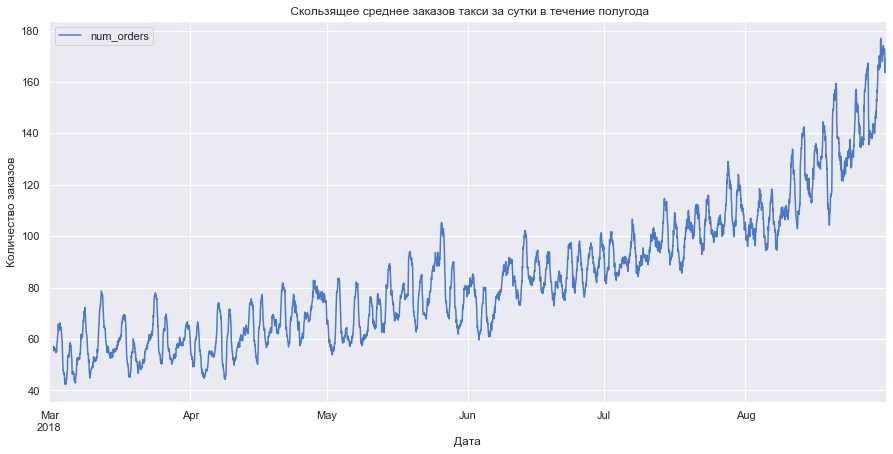

In [6]:
taxi.rolling(24).mean().plot(figsize = (15, 7),
                            title = ' Скользящее среднее заказов такси за сутки в течение полугода')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

На этом графике уже лучше видно что все время скользящее среднее растет, а значит с каждым месяцем заказов становится все больше. Попробуем теперь отследить тренд и сезонность в данных, используя для этого специальную функцию, декомпозирующую ряд на три составляющие: тренд, сезонность и остаток. Для более понятного восприятия данных ресэмплируем данные еще раз, просуммировав информацию за сутки.

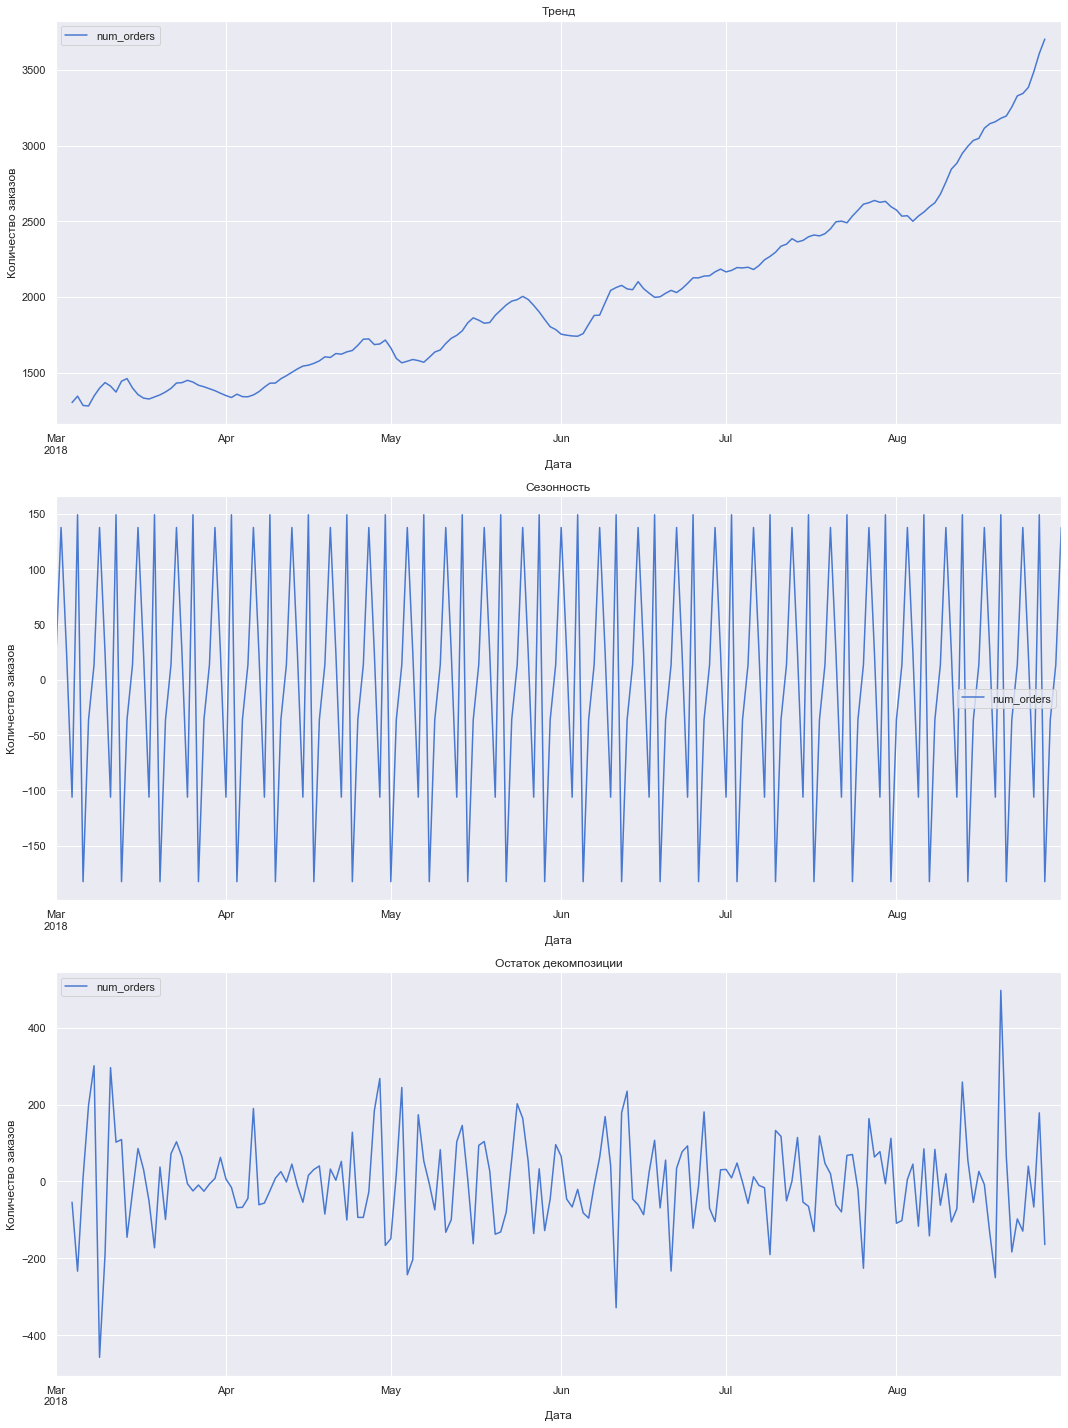

In [7]:
decomposed = seasonal_decompose(taxi.resample('1D').sum()) 

plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.tight_layout()

Тренд, который мы видели на графике скользящего среднего подтвердился и этой функцией. На графике сезонности также видна периодичность, с периодом повторения в 1 неделю. Остатки же не имеют какой-либо закономерности и являются случайными.

Взглянем также на сезонность в течение одного дня, для этого рассмотрим ближе промежуток сезонности для первых двух дней из полной почасовой сезонности.

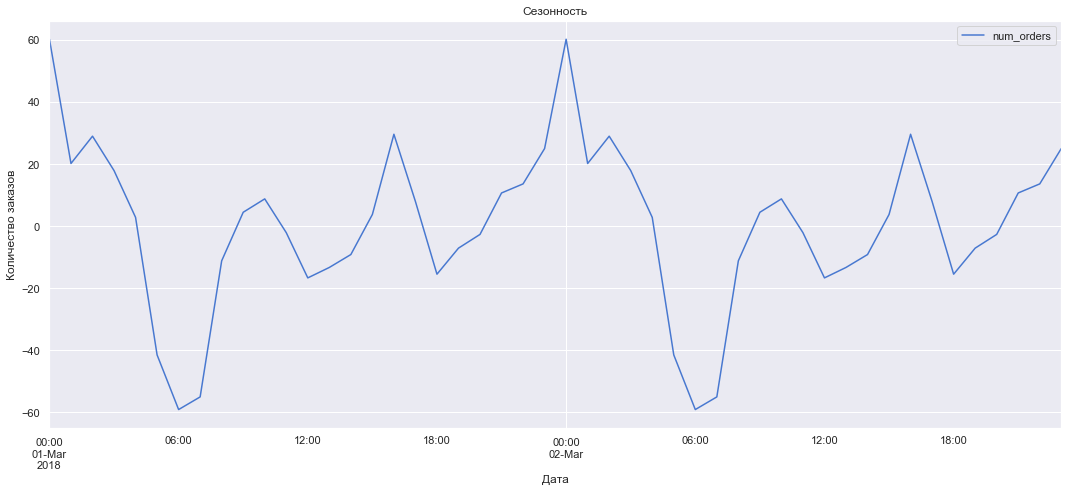

In [8]:
decomposed = seasonal_decompose(taxi) 

decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize = (15, 7))
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

Явно вижно, что к 6 утра количество заказов падает, в районе 10 и 17 часов сезонность имеет локальные пики, а к полуночи количество заказов обычно наибольшее.

# 3. Обучение <a id='step_3'></a>

В данной части работы мы подготовим данные для обучения моделей, обучим несколько разных моделей, и подберем для них оптимальные гиперпараметры.

Для начала напишем функцию `make_features`, которая будет добавлять новые признаки в таблицу, такие как месяц, день, день недели, а также количество заказов за предыдущие n часов и скользящее среднее за m дней. Количество n и m сделаем настраевым. Также эта функция будет отделять целевой признак и разделять выборку на обучающую и тестовую, отбирая для тестовой последние 10% данных. На выходе функция будет выдавать 4 массива данных: обучающие признаки, тестовые признаки, обучающий целевой признак, тестовый целевой признак и печатать размеры этих массивов. 

Также создадим функцию `best_par` которая будет принимать в себя модель, обучать её, рассчитывать на предсказаниях модели метрику, а также сравнивать её с текущей лучшей метрикой и в случае если новая окажется меньше, перезаписывать старую, а также перезаписывать значение гиперпараметра, при котором эта метрика была получена. В противном случае функция возвращает текущие наилучшие значения.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    #Для преобразований будем использовать копию таблицы данных, чтобы не записывать новые столбцы в исходную таблицу
    data_1 = data.copy()
    #Создание признаков "месяц", "день", "день недели" и "час"
    data_1['month'] = data.index.month
    data_1['day'] = data.index.day
    data_1['dayofweek'] = data.index.dayofweek
    data_1['hour'] = data.index.hour
    #Создание дополнительных столбцов со смещениями
    for lag in range(1, max_lag + 1):                                
        data_1['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #создание столбца со скользящим средним
    data_1['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    #Разделение на обучающую и тестовую выборки
    train, test = train_test_split(data_1, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    #
    features_train = train.drop('num_orders', axis = 1)
    target_train   = train['num_orders']
    features_test  = test.drop('num_orders', axis = 1)
    target_test    = test['num_orders']
    
    return features_train, features_test, target_train, target_test

In [10]:
def best_par(model,     #результаты кросс-валидации
             param_meaning,  #текущее значение подбираемого параметра
             best_param,     #лучшее значение параметра
             best_score):    #лучшее значение метрики
    global X_teach, X_valid, y_teach, y_valid
    model.fit(X_teach, y_teach)
    res = round(mean_squared_error(y_valid, model.predict(X_valid)) ** (1/2), 2)
    if res < best_score:
        return param_meaning, res     #возвращает текущие значения параметра и метрики в качестве лучших
    else:
        return best_param, best_score #возвращает лучшие значения параметра со входа

Функции готовы. Подготовим данные для обучения с помощью нашей функции. Будем использовать данные о заказах за 5 последние часов и значение скользящего среднего за 24 часа. Также выделим 10% обучающей выборки в качестве валидационной для подбора гиперпараметров.

In [11]:
X_train, X_test, y_train, y_test = make_features(taxi, 5, 24)

X_teach, X_valid, y_teach, y_valid = train_test_split(X_train, y_train, shuffle = False, test_size = 0.1)
print(X_teach.shape, X_valid.shape, y_teach.shape, y_valid.shape)

(3555, 10) (395, 10) (3555,) (395,)


Выборки получены, можно приступить к подбору гиперпараметров моделей. В данной работе мы обучим 3 модели: линейной регрессии, случайного леса и градиентного бустинга. Начнем с модели линейной регрессии.

In [13]:
lnrg = LinearRegression()
lnrg.fit(X_teach, y_teach)
rmse = round(mean_squared_error(y_valid, lnrg.predict(X_valid)) ** (1/2), 2)
print('Значение метрики RMSE =', rmse)

Значение метрики RMSE = 40.49


На валидационной выборке значение метрики получилось уже нас удовлетворяющим - 40.49. Посмотрим что она даст на тестовой выборке. 

Следующую обучим модель случайного леса.  Будем подбирать 2 гиперпараметра: сначала количество решающих деревьев, а затем - максимальную глубину. Для ускорения процесса не будем использовать подбор параметров методом сетки, а подберем их по-очереди.

In [14]:
frst_best_est = 10
best_score_frst = 100
for i in range (3, 31):
    frst = RandomForestRegressor(n_estimators = i, 
                                 n_jobs = -1, 
                                 random_state = 357)
    frst_best_est, best_score_frst = best_par(frst, i, frst_best_est, best_score_frst)

frst_best_depth = 5
for i in range (5, 21):
    frst = RandomForestRegressor(n_estimators = frst_best_est, 
                                 max_depth = i, 
                                 n_jobs = -1, 
                                 random_state = 357)
    frst_best_depth, best_score_frst = best_par(frst, i, frst_best_depth, best_score_frst)
    
print('Оптимальное количество решающих деревьев:',frst_best_est)
print('Наилучшая максимальная глубина деревьев:',frst_best_depth)
print('Значение метрики RMSE =', best_score_frst)

Оптимальное количество решающих деревьев: 14
Наилучшая максимальная глубина деревьев: 20
Значение метрики RMSE = 33.24


Метрика получилась лучше, чем у линейной регрессии - 33.24. И это ощутимо меньше 48, что хорошо.

Третья модель, которую мы будем использовать - градиентный бустинг из библиотеки LightGBM. Подбирать будем также 2 гиперпараметра - количество решающих деревьев и максимальное количество листьев дерева.

In [15]:
lgbm_best_est = 100
best_score_lgbm = 100
for i in range (10, 101, 10):
    lgbm = LGBMRegressor(n_estimators = i, 
                                 n_jobs = -1, 
                                 random_state = 357)
    lgbm_best_est, best_score_lgbm = best_par(lgbm, i, lgbm_best_est, best_score_lgbm)

lgbm_best_nl = 3
for i in range (3, 21):
    lgbm = LGBMRegressor(n_estimators = lgbm_best_est, 
                                 num_leaves = i, 
                                 n_jobs = -1, 
                                 random_state = 357)
    lgbm_best_nl, best_score_lgbm = best_par(lgbm, i, lgbm_best_nl, best_score_lgbm)
    
print('Оптимальное количество решающих элементов:',lgbm_best_est)
print('Наилучшее максимальное количество листьев дерева:',lgbm_best_nl)
print('Значение метрики RMSE =', best_score_lgbm)

Оптимальное количество решающих элементов: 90
Наилучшее максимальное количество листьев дерева: 17
Значение метрики RMSE = 31.27


У модели градиентного бустинга метрика наилучшая - 31.27. Гиперпараметры подобраны, теперь подберем оптимальное количество смещений

Подберем наилучшее количество смещений для каждой модели, дающее наименьшее значение метрики. Напишем для этого отдельную функцию, которая также будет рисовать график зависимости метрики модели от количества смещений.

In [16]:
def featurer(model, name):
    #Создание датафрейма, по которому будем строить график
    df = pd.DataFrame([], columns = ['Features', 'Score', 'Target'])
    #Дефолтное значения метрики и стартовое количество смещений, от которых будем отталкиваться
    best_rmse = 100
    best_shift = 5
    #отбрасывание тестовых 10% с конца таблицы
    global taxi
    data_train = taxi.head(int(len(taxi) * 0.9)) 
    #Обучение моделей и рассчет метрики для каждого количества смещений, с последующим добавлением в таблицу
    for i in range (5, 73):
        X_train, X_valid, y_train, y_valid = make_features(data_train, i, 24)
        model.fit(X_train, y_train)
        rmse_model = round(mean_squared_error(y_valid, model.predict(X_valid)) ** (1/2), 2) 
        df = df.append({'Features': i,
                        'Score':rmse_model,
                         'Target':48}, ignore_index=True)
        if rmse_model < best_rmse:
            best_shift = i
            best_rmse = rmse_model
    #Перенос количества смещений в индексы
    df = df.set_index('Features')
    #Отрисовка графика
    df.plot(figsize = (15, 6))    
    plt.title('Распределение метрик ' + name)
    plt.ylabel('Значение RMSE')
    plt.xlabel('Количество смещений')
    plt.show()
    print('Лучшее количество смещений '+name+':', best_shift)
    print('Наименьшее RMSE '+name+':', best_rmse)
    return best_shift

Используя эту функцию и подобранные гиперпараметры определим наилучшее количество смещений.

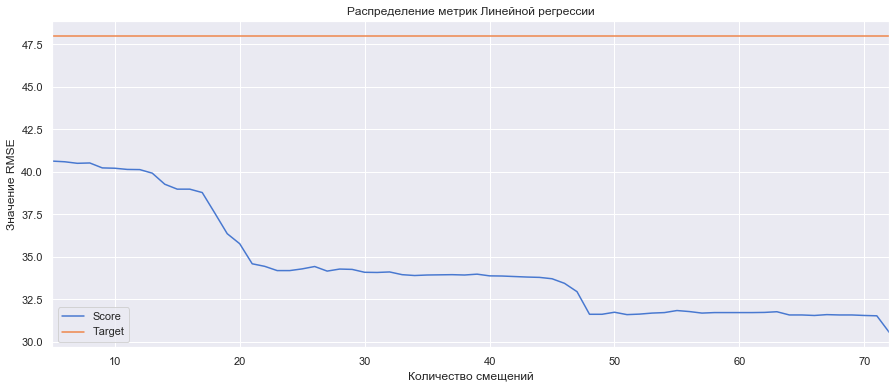

Лучшее количество смещений Линейной регрессии: 72
Наименьшее RMSE Линейной регрессии: 30.56


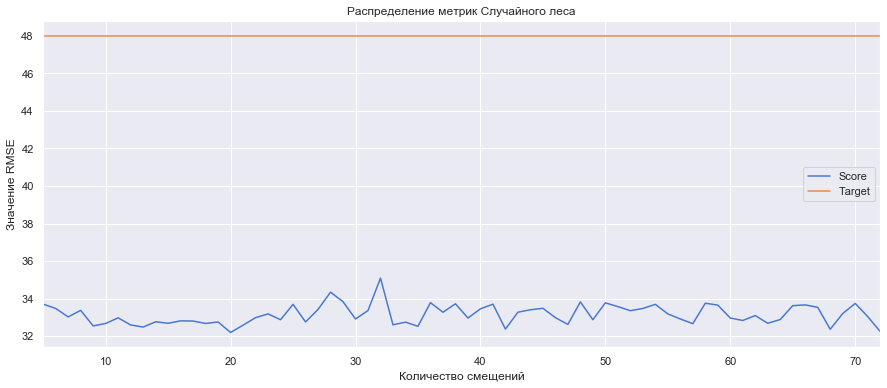

Лучшее количество смещений Случайного леса: 20
Наименьшее RMSE Случайного леса: 32.19


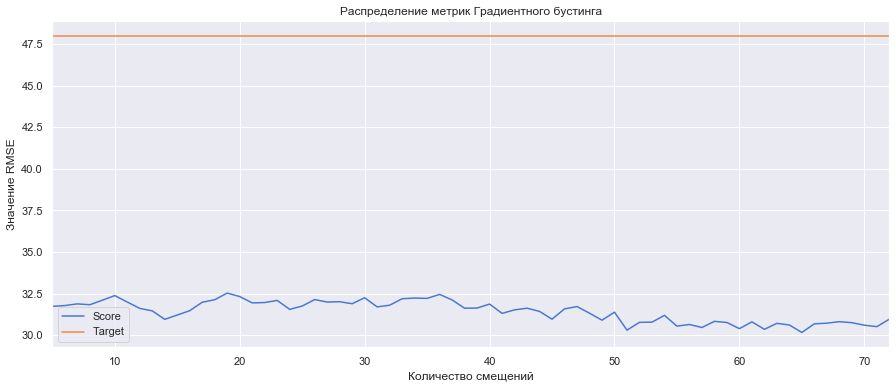

Лучшее количество смещений Градиентного бустинга: 65
Наименьшее RMSE Градиентного бустинга: 30.16


In [17]:
lnrg = LinearRegression()
frst = RandomForestRegressor(n_jobs = -1, 
                             random_state = 357, 
                             n_estimators = frst_best_est, 
                             max_depth = frst_best_depth)

lgbm = LGBMRegressor(n_jobs = -1, 
                     random_state = 357, 
                     n_estimators = lgbm_best_est, 
                     num_leaves = lgbm_best_nl)
bs_lnrg = featurer(lnrg, "Линейной регрессии")
bs_frst = featurer(frst, "Случайного леса")
bs_lgbm = featurer(lgbm, "Градиентного бустинга")

Видно, что для модели линейной регресси метрика снижается при смещении примерно на сутки и на двое. Для случайного леса смещения практически не влияют и метрика колеблется примерно в одних пределах, а для модели градиентного бустинга метрика снижается после добавления смещения на двое суток и более.

# 4. Тестирование <a id='step_4'></a>

В данной части мы проверяем модели на тестовой выборке. Вместе с рассчетом метрики выведем на экран график, на котором наложим друг на друга истинные и предсказанные моедлью значения. Чтобы избежать неразберихи для каждой модели построим свой график.

In [18]:
def prover(model, data, shifter, name):
    X_train, X_test, y_train, y_test = make_features(data, shifter, 24)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df = pd.DataFrame([], columns = ['истинные заказы', name])
    df['истинные заказы'] = y_test
    df[name] = predictions
    df = df.set_index(y_test.index)
    df.plot(figsize = (15, 6))    
    plt.title('Количество заказов. Модель ' + name)
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.show()
    print('Значение метрики RMSE =', round(mean_squared_error(y_test, predictions) ** (1/2), 2))

Теперь, на основе этой функции и гиперпараметров, подобранных в прошлой части работы, выведем на экран описанные выше графики и значения метрики на тестовой выборке.

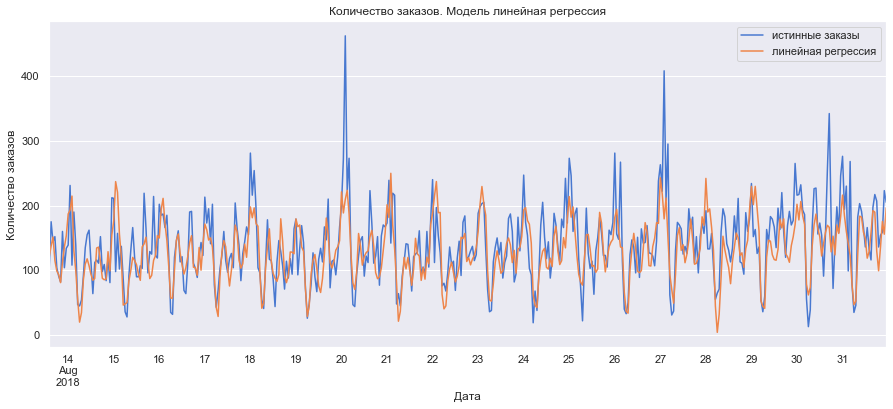

Значение метрики RMSE = 42.48


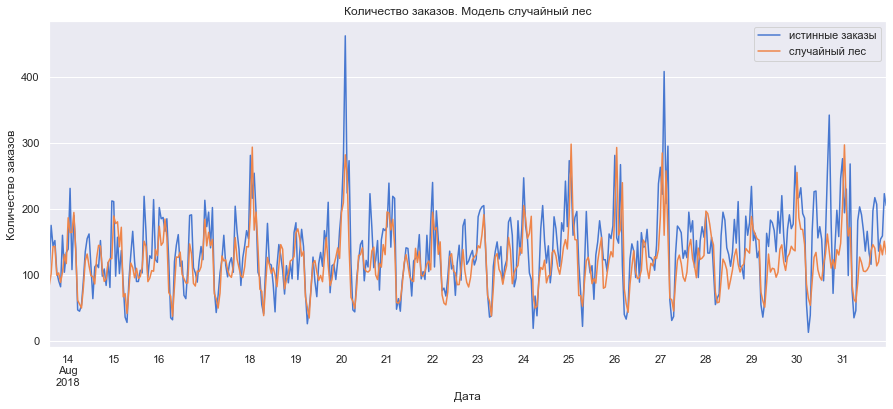

Значение метрики RMSE = 46.21


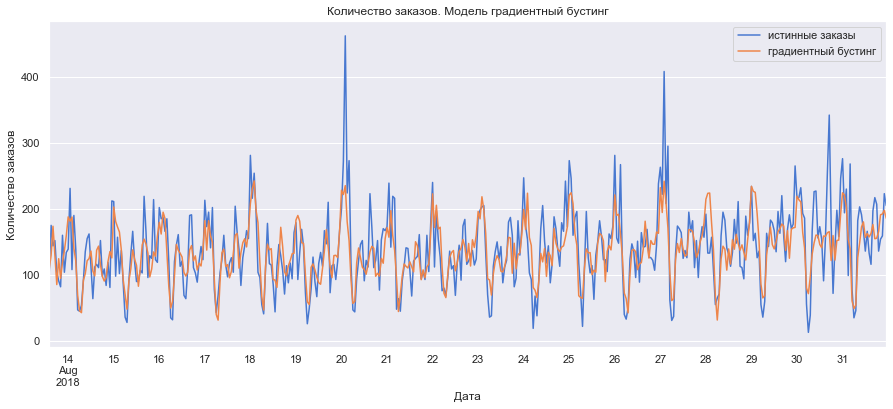

Значение метрики RMSE = 39.46


In [20]:
lnrg = LinearRegression()
frst = RandomForestRegressor(n_jobs = -1, 
                             random_state = 357, 
                             n_estimators = frst_best_est, 
                             max_depth = frst_best_depth)

lgbm = LGBMRegressor(n_jobs = -1, 
                     random_state = 357, 
                     n_estimators = lgbm_best_est, 
                     num_leaves = lgbm_best_nl)
prover(lnrg, taxi, bs_lnrg, "линейная регрессия")
prover(frst, taxi, bs_frst, "случайный лес")
prover(lgbm, taxi, bs_lgbm, "градиентный бустинг")

Все модели соблюли условие *RMSE* <= 48. Наилучшей оказалась модель градиентного бустинга, давшая *RMSE* 39.46, затем идет модель случайного леса с метрикой 46.21 и на последнем месте линейная регрессия, с показателем *RMSE* 42.48. На графиках можно увидеть, что все модели в основном дают близкие к правде предсказания, основная ошибка идет на аномальных пиках. При этом модель случайного леса чуть лучше предсказывает значения в пиках, чем остальные модели. Хуже всего предсказывает пики модель градиентного бустинга, однако она точнее предсказывает *обычные* значения.

# 5. Общий вывод <a id='step_5'></a>

В данной работе перед нами стояла задача создания модели для компании-агрегатора такси, которая должна предсказывать количество заказов в аэропортах в следующий час привлечения большего количества водителей. Заказчик поставил условие, что значение метрики RMSE не должно быть больше 48. От компании мы получили исторические данные о заказах такси в аэропортах за периодс марта по август 2018 года. Изучив эти данные мы обнаружили что постепенно количество заказов растет, а также что наблюдается некоторая недельная и суточная периодичности в количестве заказов. На основе предоставленных данных мы построили три модели и подобрали их параметры и параметры обработки данных так, что получили на этих моделях следующие результаты метрики *RMSE*:

1. Линейная регрессия  - 42.48
2. Случайный лес       - 46.21
3. Градиентный бустинг - 39.46

Таким образом, все обученные модели удовлетворили требование заказчика о том, что метрика *RMSE* должна быть не более 48. Наилучшее предсказание дала модель градиентного бустинга.